In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import src.plotter.utils as utils
from src.plotter.main import *

In [2]:
BATCH_RESULT_PATH = "C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/UNIF/"
OUTPUT_DIRECTORY_PATH = f"C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/plot/UNIF/aggregated-{BATCH_RESULT_PATH.split('/')[-2]}/"

DEADLINES = [1, 5]
TIMESLOTS = 10000

In [3]:
def get_results_path(start_path=BATCH_RESULT_PATH):
    to_ret = []

    for file in os.listdir(start_path):
        if os.path.isdir(os.path.join(start_path, file)):
            to_ret.append(os.path.join(start_path, file, 'results.data'))

    return to_ret

results_path = get_results_path()

In [4]:
# slices_std = split_stats_per_slice(imported_data[policy_index]['environment_data_std'])

In [5]:
BATCH_RESULT_PATH

'C:/Users/SK3LA/Desktop/WORKSPACE/1_TSP/BATCH_FINALI/@RISULTATI@/res/UNIF/'

In [6]:
# getting policies_aggregated_stats 

policies_aggregated_stats = None

for r in results_path:
    imported_data = utils.import_serialized_data(r)
    if policies_aggregated_stats is None:
        policies_aggregated_stats = [{'name': imported_data[i]['name'], 'stats_per_slice': []} for i in range(len(imported_data))]

    for policy_index in range(len(imported_data)):
        policies_aggregated_stats[policy_index]['stats_per_slice'].append(
            {
             # the way we calculate the server_cap assumes the directory name like "something_NUMBEROFSERVERS"
             'server_cap': r.replace("\\", "/").split('/')[-2].split('_')[1],
             'slices': []
             }
        )

        slices = filter_stats_per_slice(split_stats_per_slice(imported_data[policy_index]['environment_data']))
#         slices_std = split_stats_per_slice(imported_data[policy_index]['environment_data_std'])

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[0]['processed_jobs']),
                'incoming_jobs': sum(slices[0]['incoming_jobs']),
                'lost_jobs': sum(slices[0]['lost_jobs']),
                'toolate_jobs': sum(slices[0]['processed_jobs']) * sum(slices[0]['wait_time_in_the_system'][DEADLINES[0]:]),
                'cost': sum(slices[0]['cost']),
                'cost_component': np.array(slices[0]['cost_component']).sum(0).tolist(),
#                 'cost_std': sum(slices_std[0]['cost'])
             }
        )

        policies_aggregated_stats[policy_index]['stats_per_slice'][-1]['slices'].append(
            {
                'processed_jobs': sum(slices[1]['processed_jobs']),
                'incoming_jobs': sum(slices[1]['incoming_jobs']),
                'lost_jobs': sum(slices[1]['lost_jobs']),
                'toolate_jobs': sum(slices[1]['processed_jobs']) * sum(slices[1]['wait_time_in_the_system'][DEADLINES[1]:]),
                'cost': sum(slices[1]['cost']),
                'cost_component': np.array(slices[1]['cost_component']).sum(0).tolist(),
#                 'cost_std': sum(slices_std[1]['cost'])
            }
        )
        
dataframes = []

for policy in policies_aggregated_stats:
    servers_list = []
    processed_on_time_percent = [[], []]
    processed_too_late_percent = [[], []]
    lost_percent = [[], []]

    cost_job = [[], []]
    cost_server = [[], []]
    cost_lost = [[], []]
    cost_alloc = [[], []]
    cost_dealloc = [[], []]

    costs = [[], []]
    
#     costs_std = [[], []]

    for s in policy['stats_per_slice']:
        servers_list.append(s['server_cap'])

        lost_percent[0].append((s['slices'][0]['lost_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        lost_percent[1].append((s['slices'][1]['lost_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        processed_too_late_percent[0].append((s['slices'][0]['toolate_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_too_late_percent[1].append((s['slices'][1]['toolate_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        s['slices'][0]['processed_jobs'] -= s['slices'][0]['toolate_jobs']
        s['slices'][1]['processed_jobs'] -= s['slices'][1]['toolate_jobs']

        processed_on_time_percent[0].append((s['slices'][0]['processed_jobs'] * 100) / s['slices'][0]['incoming_jobs'])
        processed_on_time_percent[1].append((s['slices'][1]['processed_jobs'] * 100) / s['slices'][1]['incoming_jobs'])

        cost_job[0].append(s['slices'][0]['cost_component'][0])
        cost_job[1].append(s['slices'][1]['cost_component'][0])

        cost_server[0].append(s['slices'][0]['cost_component'][1])
        cost_server[1].append(s['slices'][1]['cost_component'][1])

        cost_lost[0].append(s['slices'][0]['cost_component'][2])
        cost_lost[1].append(s['slices'][1]['cost_component'][2])

        cost_alloc[0].append(s['slices'][0]['cost_component'][3])
        cost_alloc[1].append(s['slices'][1]['cost_component'][3])

        cost_dealloc[0].append(s['slices'][0]['cost_component'][4])
        cost_dealloc[1].append(s['slices'][1]['cost_component'][4])

        costs[0].append(s['slices'][0]['cost'])
        costs[1].append(s['slices'][1]['cost'])
        
#         costs_std[0].append(s['slices'][0]['cost_std'])
#         costs_std[1].append(s['slices'][1]['cost_std'])

    dataframes.append(
        {
            'name': policy['name'],
            'slices': [
                pd.DataFrame({  # slice high priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[0],
                    'processed_too_late': processed_too_late_percent[0],
                    'lost': lost_percent[0],
                    'cost_job': cost_job[0],
                    'cost_server': cost_server[0],
                    'cost_lost': cost_lost[0],
                    'cost_alloc': cost_alloc[0],
                    'cost_dealloc': cost_dealloc[0],
                    'cost_sum': costs[0],
#                     'cost_sum_std': costs_std[0]
                }),
                pd.DataFrame({  # slice low priority
                    'server': servers_list,
                    'processed_on_time': processed_on_time_percent[1],
                    'processed_too_late': processed_too_late_percent[1],
                    'lost': lost_percent[1],
                    'cost_job': cost_job[1],
                    'cost_server': cost_server[1],
                    'cost_lost': cost_lost[1],
                    'cost_alloc': cost_alloc[1],
                    'cost_dealloc': cost_dealloc[1],
                    'cost_sum': costs[1],
#                     'cost_sum_std': costs_std[1]
                })  # .sort_values(by=["server"]).set_index("server")
            ]
        }
    )

    dataframes[-1]['slices'][0]['server'] = dataframes[-1]['slices'][0].astype(int)
    dataframes[-1]['slices'][1]['server'] = dataframes[-1]['slices'][1].astype(int)
    dataframes[-1]['slices'][0] = dataframes[-1]['slices'][0].sort_values(by=["server"]).set_index("server")
    dataframes[-1]['slices'][1] = dataframes[-1]['slices'][1].sort_values(by=["server"]).set_index("server")

In [7]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_processed_on_time_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': slice_0[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_0[1]['processed_on_time'].to_list(),
        'UniformStatic': slice_0[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_0[3]['processed_on_time'].to_list(),
                 })

df_processed_on_time_slice_0['server'] = df_processed_on_time_slice_0['server'].astype(int)
df_processed_on_time_slice_0 = df_processed_on_time_slice_0.sort_values(by=["server"]).set_index("server")


    
df_processed_on_time_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': slice_1[0]['processed_on_time'].to_list(),
        'SimplifiedMDP': slice_1[1]['processed_on_time'].to_list(),
        'UniformStatic': slice_1[2]['processed_on_time'].to_list(),
        'PriorityStatic': slice_1[3]['processed_on_time'].to_list(),
    })

df_processed_on_time_slice_1['server'] = df_processed_on_time_slice_1['server'].astype(int)
df_processed_on_time_slice_1 = df_processed_on_time_slice_1.sort_values(by=["server"]).set_index("server")

In [8]:
df_processed_on_time_slice_0

,SequentialMDP,SimplifiedMDP,UniformStatic,PriorityStatic
server,,,,
2,2.361950,2.389390,0.004214,2.402461
3,28.274483,28.347587,2.379770,28.201962
4,68.292884,68.299873,2.376904,68.309387
5,90.575915,90.588936,28.368700,90.509622
6,98.485978,98.510651,28.272907,98.498890
7,98.499596,98.505346,68.193976,99.936966
8,98.518535,98.513173,68.351676,99.939981
9,98.509166,98.497712,90.507130,99.940325
10,98.495777,98.515905,90.511124,99.941743


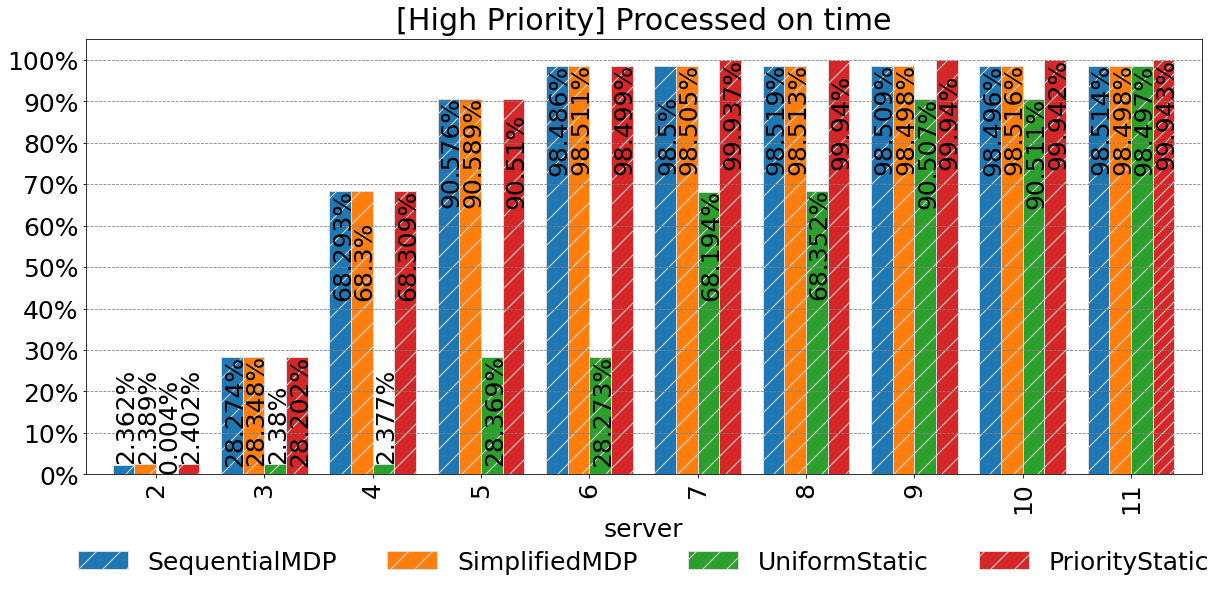

In [16]:
patterns =('/','//', '\\', '\\\\')

ax = df_processed_on_time_slice_0[:10].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
    )
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[High Priority] Processed on time", pad=10)
yticks = np.arange(0, 101, 10)
ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
plt.yticks(yticks, ylabels)


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    if i.get_height() > 20:
        ax.text(i.get_x() + 0.015, i.get_height() - 25,
                str(round((i.get_height()), 3)) + '%', fontsize=25, color='black', rotation=90)
    else:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() + 0.015, i.get_height() + 1.5,
                str(round((i.get_height()), 3)) + '%', fontsize=25, color='black', rotation=90)

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, borderaxespad=0.01, frameon=False)
    
# plt.show()

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}processed_on_time_slice0_allpolicy_JUPYTER", bbox_inches='tight')
            
            

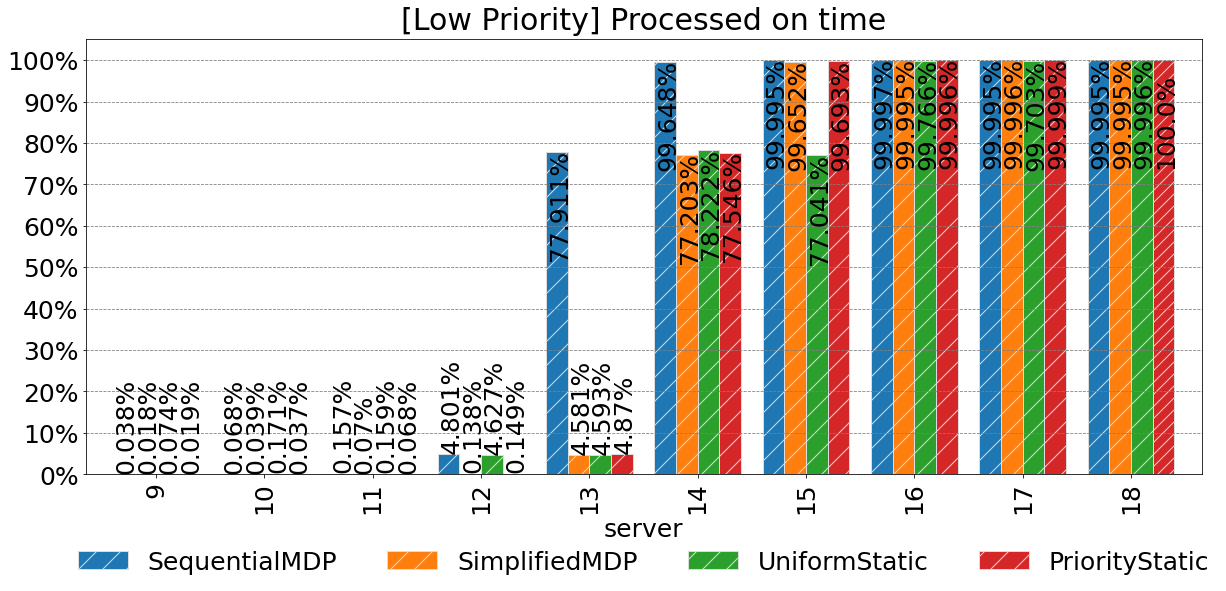

In [10]:
patterns =('/','//', '\\', '\\\\')

ax = df_processed_on_time_slice_1[7:17].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
    )
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[Low Priority] Processed on time", pad=10)
yticks = np.arange(0, 101, 10)
ylabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
plt.yticks(yticks, ylabels)


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    if i.get_height() > 20:
        ax.text(i.get_x() + 0.015, i.get_height() - 25,
                str(round((i.get_height()), 3)) + '%', fontsize=25, color='black', rotation=90)
    else:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() + 0.015, i.get_height() + 1.5,
                str(round((i.get_height()), 3)) + '%', fontsize=25, color='black', rotation=90)

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, borderaxespad=0.01, frameon=False)
    
# plt.show()

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}processed_on_time_slice1_allpolicy_JUPYTER", bbox_inches='tight')
            

In [11]:
slice_0 = [d['slices'][0] for d in dataframes]
slice_1 = [d['slices'][1] for d in dataframes]

df_cost_slice_0 = \
    pd.DataFrame({
        'server': slice_0[0].index.to_list(),
        'SequentialMDP': (slice_0[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_0[1]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_0[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_0[3]['cost_sum']/TIMESLOTS).to_list(),
                 })

df_cost_slice_0['server'] = df_cost_slice_0['server'].astype(int)
df_cost_slice_0 = df_cost_slice_0.sort_values(by=["server"]).set_index("server")


    
df_cost_slice_1 = \
    pd.DataFrame({
        'server': slice_1[0].index.to_list(),
        'SequentialMDP': (slice_1[0]['cost_sum']/TIMESLOTS).to_list(),
        'SimplifiedMDP': (slice_1[1]['cost_sum']/TIMESLOTS).to_list(),
        'UniformStatic': (slice_1[2]['cost_sum']/TIMESLOTS).to_list(),
        'PriorityStatic': (slice_1[3]['cost_sum']/TIMESLOTS).to_list(),
    })

df_cost_slice_1['server'] = df_cost_slice_1['server'].astype(int)
df_cost_slice_1 = df_cost_slice_1.sort_values(by=["server"]).set_index("server")

In [12]:
slice_0[0]

,processed_on_time,processed_too_late,lost,cost_job,cost_server,cost_lost,cost_alloc,cost_dealloc,cost_sum
server,,,,,,,,,
2,2.361950,59.771848,37.854481,2.859390,0.192800,0.938613,0.000000,0.000000e+00,3.990803
3,28.274483,57.822562,13.895613,1.402422,0.289200,0.344680,0.000000,0.000000e+00,2.036302
4,68.292884,28.492489,3.213316,0.455947,0.385600,0.079784,0.000000,0.000000e+00,0.921331
5,90.575915,9.088248,0.334305,0.069196,0.482000,0.008286,0.000000,0.000000e+00,0.559482
6,98.485978,1.498512,0.015261,0.003317,0.578400,0.000379,0.000000,0.000000e+00,0.582096
7,98.499596,1.485568,0.014681,0.003397,0.578504,0.000365,0.000104,1.082500e-07,0.582371
8,98.518535,1.465824,0.015516,0.003191,0.578500,0.000384,0.000100,1.042500e-07,0.582177
9,98.509166,1.476157,0.014646,0.003205,0.578492,0.000363,0.000092,9.525000e-08,0.582152
10,98.495777,1.487401,0.016728,0.003156,0.578499,0.000415,0.000099,1.027500e-07,0.582169


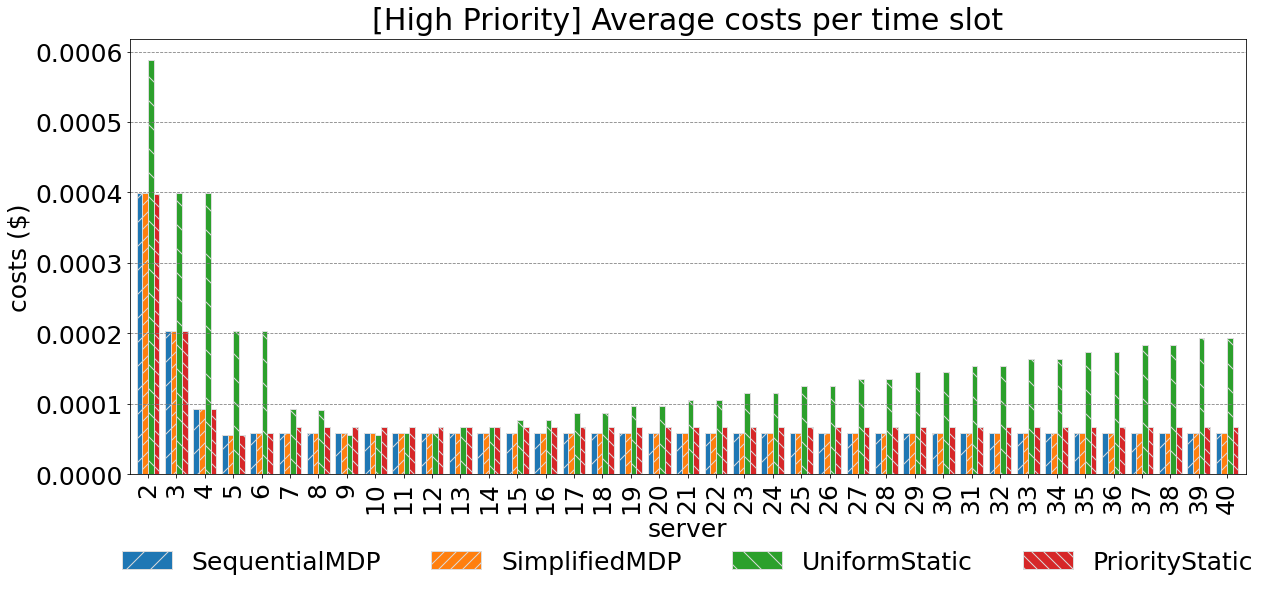

In [13]:
patterns =('/','//', '\\', '\\\\')

ax = df_cost_slice_0.plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
#         logy=True
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[High Priority] Average costs per time slot", pad=10)
ax.set_ylabel('costs ($)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_slice0_allpolicy_JUPYTER", bbox_inches='tight')

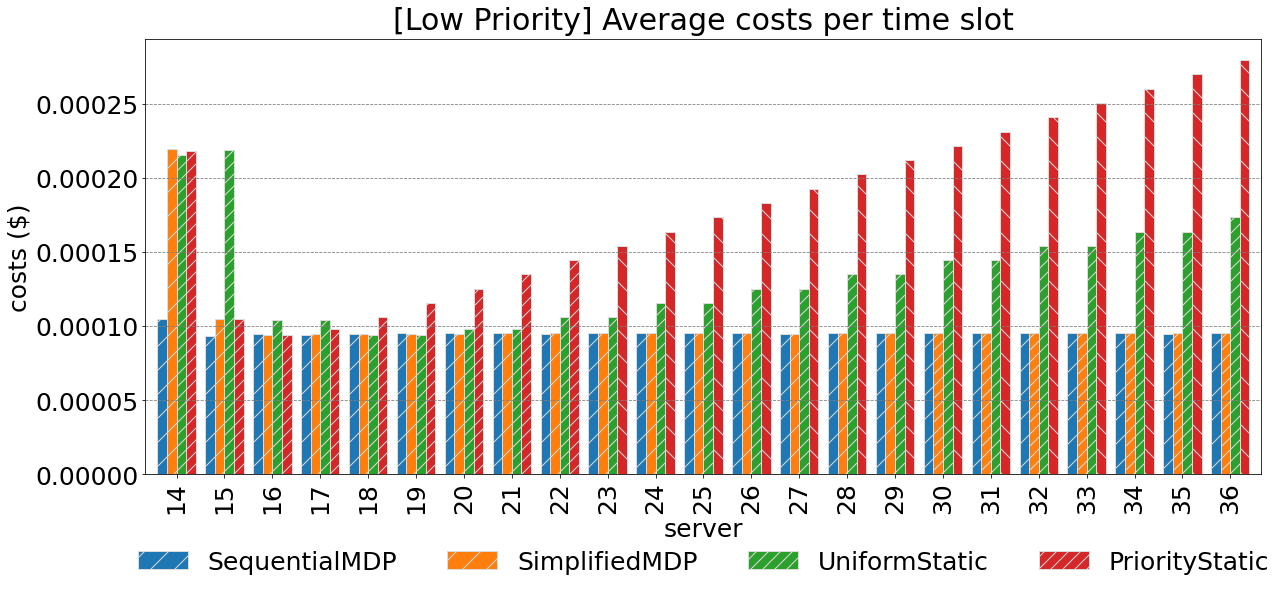

In [14]:
patterns =('/','//', '\\', '\\\\')

ax = df_cost_slice_1[12:35].plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
#         logy=True
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[Low Priority] Average costs per time slot", pad=10)
ax.set_ylabel('costs ($)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_slice1_allpolicy_JUPYTER", bbox_inches='tight')

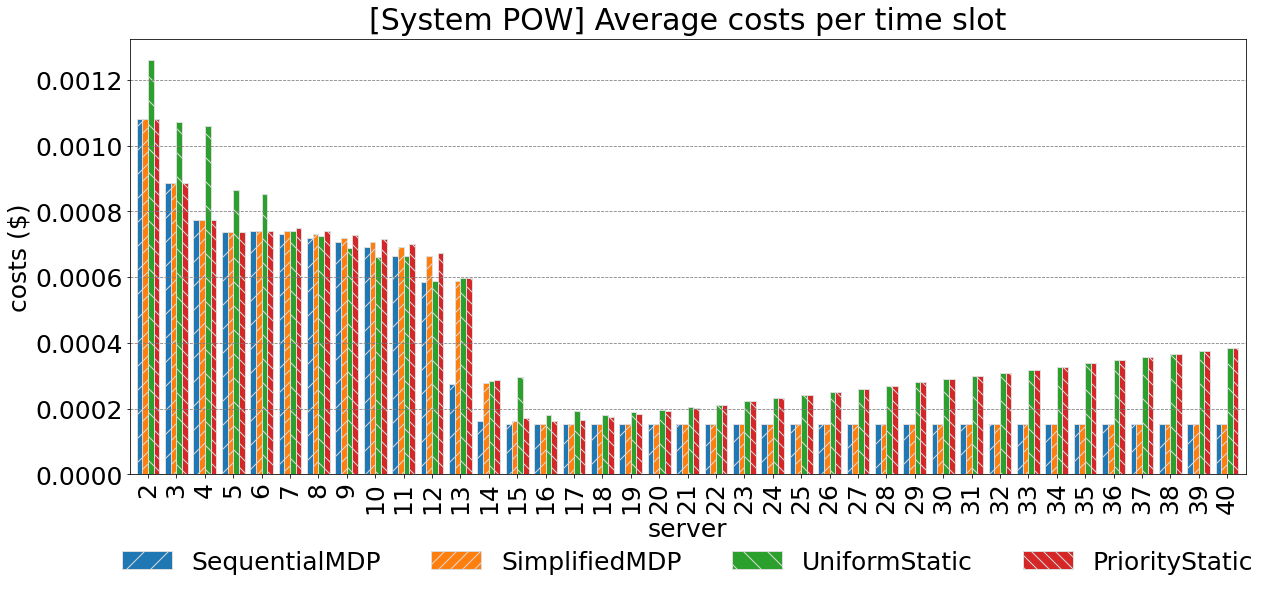

In [15]:
patterns =('/','//', '\\', '\\\\')

ax = (df_cost_slice_0 + df_cost_slice_1).plot(
        kind='bar',
        stacked=False,
        figsize=(20, 8),
        width=0.8,
#         logy=True
    )

ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_title(f"[System POW] Average costs per time slot", pad=10)
ax.set_ylabel('costs ($)')

plt.rcParams.update({'font.size': 25})
fig_background_color = 'skyblue'
fig_border = 'steelblue'

bars = ax.patches

hatches = [p for p in patterns for i in range(len(df_processed_on_time_slice_0))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('gainsboro')
    
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, borderaxespad=0.01, frameon=False)

plt.savefig(f"{OUTPUT_DIRECTORY_PATH}cost_allslice_allpolicy_JUPYTER", bbox_inches='tight')